# Benign/Malignant Breast Cancer Prediction with K-Means, GMM, and PCA

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
import seaborn as sns
import numpy.linalg as la
from sklearn.preprocessing import normalize
from matplotlib import colors as mcolors
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import mixture
%matplotlib inline

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.data.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


# Data Cleaning

In [3]:
df.isnull().any().any()

False

In [4]:
df.rename(columns={0:'id',1:'clump thickness',2:'uniformity of cellsize',
           3:'uniformity of cell shape',4:'marginal adhesion', 
           5:'single epithelial cell size',6:'bare nuclei', 
           7:'bland chromatin',8:'normal nucleoli',9:'mitosis',10:'class'},inplace=True)

Data description of each column:                                        
Sample code number: id number                                               
Clump Thickness: 1 - 10                                                  
Uniformity of Cell Size: 1 - 10                                     
Uniformity of Cell Shape: 1 - 10                                              
Marginal Adhesion: 1 - 10                                
Single Epithelial Cell Size: 1 - 10                                
Bare Nuclei: 1 - 10                                          
Bland Chromatin: 1 - 10                                       
Normal Nucleoli: 1 - 10                            
Mitoses: 1 - 10                                       
Class: (2 for benign, 4 for malignant)                            

In [5]:
df['class'] = df['class'].replace(to_replace = 2, value = 0) #benign
df['class'] = df['class'].replace(to_replace = 4, value = 1) #malignant

changing 2 and 4 to 0 and 1 for benign and malignant

In [6]:
df['bare nuclei'] = df['bare nuclei'].replace(to_replace = '?', value = None) 

we didnt have any null values but we had 16 question marks in bare nuclei which we replaced with null

In [7]:
df['bare nuclei'] = df['bare nuclei'].astype('int64')

In [8]:
df = df.drop(columns=['id']) #dropping id
data = df #creating a new dataframe that will keep the class column which contains the actual classifications
data #class column dataframe

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


We created two dataframes: df is the dataframe without the class column, which idetifies the tumors as belign or malignant, and data includes the class colum. We use df to run kmeans/MGG and data to check how well our models worked.

In [9]:
df = df.drop(columns='class') #dropping class column to exclude it from clustering algorithm
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


# PCA

In [10]:
# Taken from HW 4
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [11]:
# Taken from HW 4
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [12]:
dfarr = df.to_numpy().T #convert to matrix/numpy array
dfarr

array([[ 5,  5,  3, ...,  5,  4,  4],
       [ 1,  4,  1, ..., 10,  8,  8],
       [ 1,  4,  1, ..., 10,  6,  8],
       ...,
       [ 3,  3,  3, ...,  8, 10, 10],
       [ 1,  2,  1, ..., 10,  6,  4],
       [ 1,  1,  1, ...,  2,  1,  1]], dtype=int64)

In [13]:
mean = np.reshape(np.mean(dfarr, axis = 1),(9,1))
A = dfarr - (np.matlib.repmat(mean, 1,699)) # matrix of mean subtracted data

# implementing the transpose trick - finding eigenvectors of A'A
eigvals_old, Vold = np.linalg.eig(np.dot(A.T,A)) 
V, D = eigsort(Vold, eigvals_old) # sorting eigenvectors in order of decreasing eigenvalues

U = normc(np.dot(A,V)) # matrix of eigenfaces
c = np.dot(U.T, A) # principal component coordinates

<ipython-input-11-51f6e317775b>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [14]:
# looking at first 3 principal component coordinates
data['X'] = c[0]
data['Y'] = c[1]
data['Z'] = c[2]
df['X'] = c[0]
df['Y'] = c[1]
df['Z'] = c[2]

Running PCA on and using the first three columns to create X, Y, and Z points for each datapoint and adding these columns to both the df and data dataframes.

In [15]:
data

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,class,X,Y,Z
0,5,1,1,1,2,1,3,1,1,0,4.437523,0.140152,1.739688
1,5,4,4,5,7,10,3,2,1,0,-4.842940,-4.875919,-0.861617
2,3,1,1,1,2,2,3,1,1,0,4.594002,-0.603916,-0.027812
3,6,8,8,1,3,4,3,7,1,0,-5.145849,3.458943,2.032486
4,4,1,1,3,2,1,3,1,1,0,4.072230,-0.037962,-0.055371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0,4.928586,-0.445218,0.130176
695,2,1,1,1,2,1,1,1,1,0,5.916401,0.197057,-0.606264
696,5,10,10,3,7,3,8,10,2,1,-10.319805,7.208938,-0.794679
697,4,8,6,4,3,4,10,6,1,1,-6.449759,2.488778,-1.817876


Text(0.5, 1.0, '2D datapoints w/o classification')

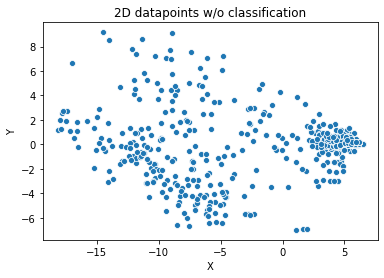

In [16]:
sns.scatterplot(x = 'X', y = 'Y', data = data) #actual clusters
plt.title('2D datapoints w/o classification')

Text(0.5, 1.0, '2D datapoints with actual classification')

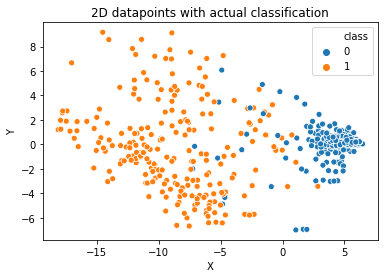

In [17]:
sns.scatterplot(x = 'X', y = 'Y', hue = 'class', data = data) #actual clusters
plt.title('2D datapoints with actual classification')

Text(0.5, 0.92, '3D datapoints w/o classification')

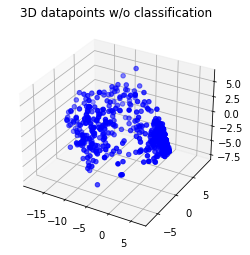

In [18]:
#%matplotlib qt
#uncomment the line above and rerun for interactable 3D plot
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data['X'],data['Y'],data['Z'], color='blue')
plt.title('3D datapoints w/o classification')

Text(0.5, 0.92, '3D datapoints with actual classification')

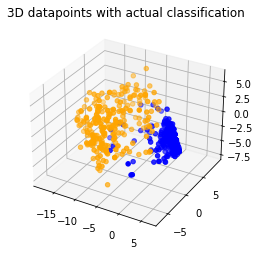

In [19]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(data['class']==1)]['X'],data[(data['class']==1)]['Y'],data[(data['class']==1)]['Z'], color='orange')
ax.scatter3D(data[(data['class']==0)]['X'],data[(data['class']==0)]['Y'],data[(data['class']==0)]['Z'], color='blue')
plt.title('3D datapoints with actual classification')

Here, we use PCA to plot the actual cluster assingments using the class column from dataframe data. The orange points represents malignant tumors and the blue are benign. Already, we can see two somewhat distinct clusters that we will later compare to our K-means clusters to determine the accuracy of the model. We've plotted in both 2D and 3D to get a better visualization of the multidimensional data. Later, we will run K-means plotting in both 2D and 3D, though the cluster assignments will not change.

# K-Means

In [20]:
df['K-Means Raw'] = 0
df['K-Means PCA'] = 0
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,X,Y,Z,K-Means Raw,K-Means PCA
0,5,1,1,1,2,1,3,1,1,4.437523,0.140152,1.739688,0,0
1,5,4,4,5,7,10,3,2,1,-4.842940,-4.875919,-0.861617,0,0
2,3,1,1,1,2,2,3,1,1,4.594002,-0.603916,-0.027812,0,0
3,6,8,8,1,3,4,3,7,1,-5.145849,3.458943,2.032486,0,0
4,4,1,1,3,2,1,3,1,1,4.072230,-0.037962,-0.055371,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,4.928586,-0.445218,0.130176,0,0
695,2,1,1,1,2,1,1,1,1,5.916401,0.197057,-0.606264,0,0
696,5,10,10,3,7,3,8,10,2,-10.319805,7.208938,-0.794679,0,0
697,4,8,6,4,3,4,10,6,1,-6.449759,2.488778,-1.817876,0,0


Note: The following K-Means code has been modified from our own solutions in HW2

In [21]:
# calculating euclidean distances between each datapoint and each cluster
def calcSqDistances(X, Kmus): 
    N = np.shape(X)[0]
    K = Kmus.shape[0]
    D = [] 
    for point in X:
        for kpoint in Kmus:
            D.append(np.sqrt(np.sum((point - kpoint)**2)))
    D = np.array(D)
    D = D.reshape((N, K))                 
    return D

In [22]:
# creating the responsibility matrix- assigning datapoints to cluster based on minimum distances
def determineRnk(sqDmat):
    m,n = sqDmat.shape
    for arr in sqDmat:
        index = np.argmin(arr, axis = None, out = None)
        for i in range(n):
            if not i==index:
                arr[i] = 0
        arr[index] = 1
    return sqDmat

In [23]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk,axis=0))).T

In [24]:
def runKMeans3D(K, data):
    X = data.to_numpy()
    if data.shape[1] > 3: 
        X = data.iloc[:,0:9].to_numpy() #making sure to exclude the PCA data if we're running on original data
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus); # N by K distance matrix
        Rnk = determineRnk(sqDmat) # N by K responsibility matrix
        KmusOld = Kmus 
        clus = Rnk.T[0]
        clus = clus.astype('int')
        data['Rnk'] = clus
        Kmus = recalcMus(X, Rnk) # recalculate K values based on cluster assignments
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.scatter3D(data[(data['Rnk']==1)]['X'],data[(data['Rnk']==1)]['Y'],data[(data['Rnk']==1)]['Z'], color='orange')
        ax.scatter3D(data[(data['Rnk']==0)]['X'],data[(data['Rnk']==0)]['Y'],data[(data['Rnk']==0)]['Z'], color='blue')
        plt.show()    
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break   
        
    return Rnk.astype('int')

In [25]:
def runKMeans(K, data):
    X = data.to_numpy()
    if data.shape[1] > 2: 
        X = data.iloc[:,0:9].to_numpy() #making sure to exclude the PCA data if we're running on original data
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus);
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus 
        clus = Rnk.T[0]
        clus = clus.astype('int')
        data['Rnk'] = clus
        Kmus = recalcMus(X, Rnk)
        sns.scatterplot(x = 'X', y = 'Y', hue = 'Rnk', data = data)
        if Kmus.shape[1] > 2: #for when data is more than two dimensions
            c = np.dot(U.T, Kmus[:,0:9].T-mean) #PCA for the Kmu points which are 9 dimensional in this case
            plt.scatter(c[0],c[1],marker='x',color='k',s=80)
        else:
            plt.scatter(Kmus[0][0],Kmus[0][1],marker='x',color='k',s=80) #plotting mean center for cluster 1
            plt.scatter(Kmus[1][0],Kmus[1][1],marker='x',color='k',s=80) #plotting mean center for cluster 2
        plt.show()
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break               
    return Rnk.astype('int')

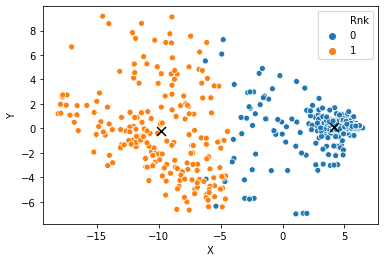

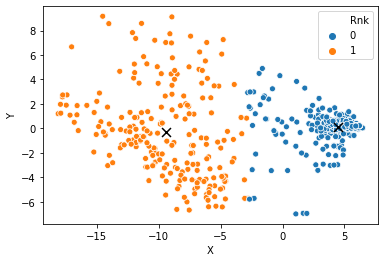

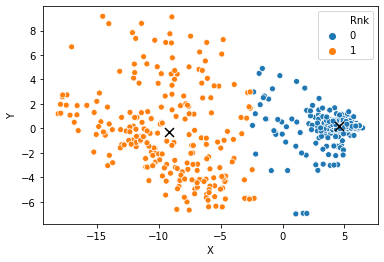

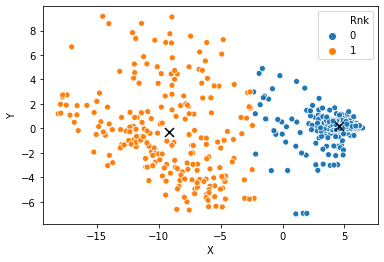

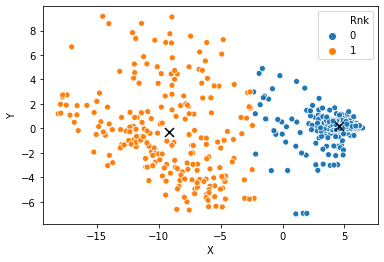

In [32]:
# PCA done after K-means only to visualize
U.shape
IID_Rnk = runKMeans(2, df) #Raw data but 2D plotting
df['K-Means Raw'] = IID_Rnk

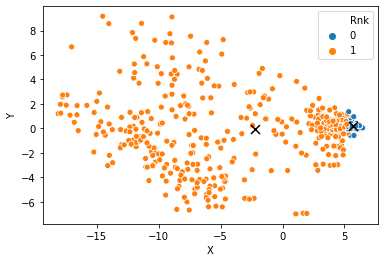

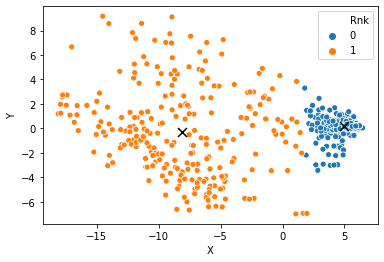

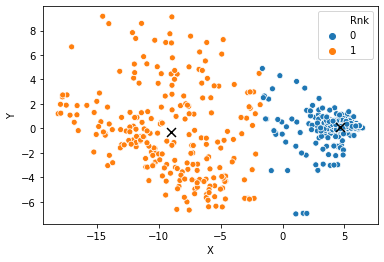

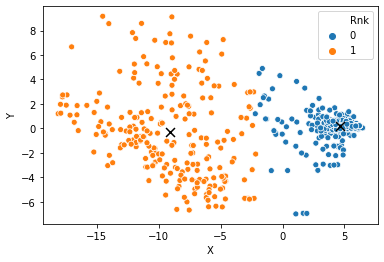

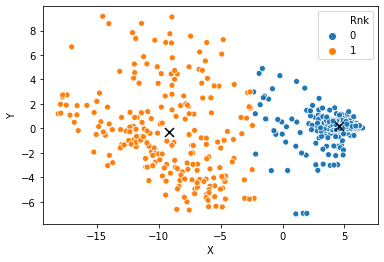

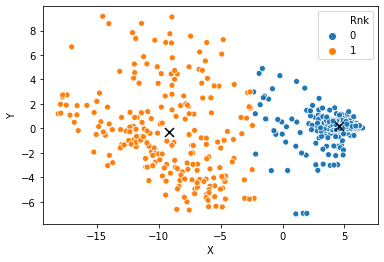

In [27]:
#k means on 2 dimensional PCA data taking top 2 principal components (K-means after PCA)
a = df.iloc[:,9:11] 
IID_PCA_Rnk = runKMeans(2, a)
df['K-Means PCA'] = IID_PCA_Rnk

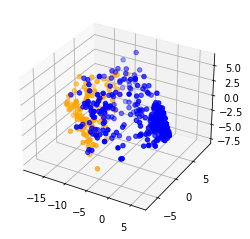

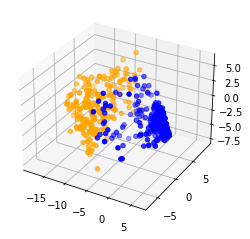

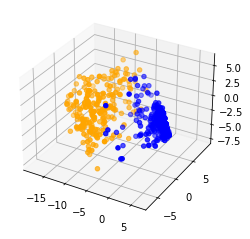

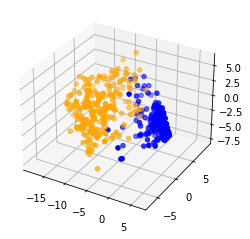

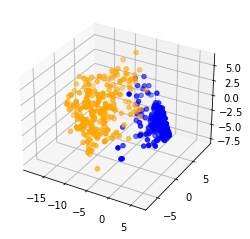

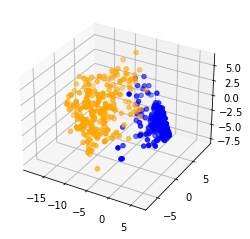

In [39]:
# PCA done after K-means only to visualize
IIID_Rnk = runKMeans3D(2,df) #K-Means on raw data same as before but with 3D plotting cause its fancy
df['K-Means Raw'] = IIID_Rnk

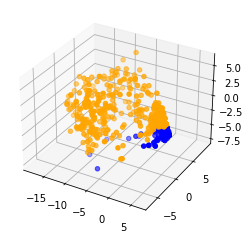

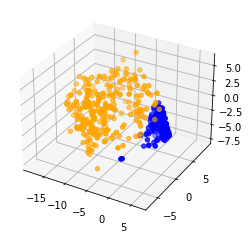

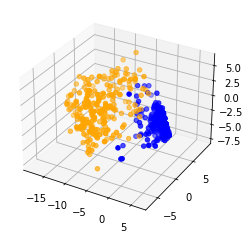

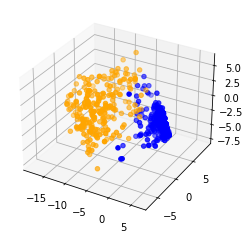

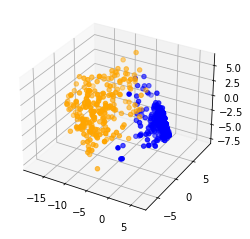

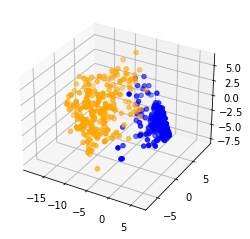

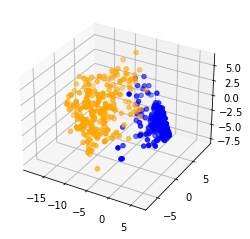

In [29]:
# k means on the 3 dimensional PCA data top 3 principal components (K-means after PCA)
b = df.iloc[:,9:12] 
IIID_PCA_Rnk = runKMeans3D(2, b)
df['K-Means PCA'] = IIID_PCA_Rnk

In [40]:
df = df.drop(columns = ['Rnk'])
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,X,Y,Z,K-Means Raw,K-Means PCA
0,5,1,1,1,2,1,3,1,1,4.437523,0.140152,1.739688,0,0
1,5,4,4,5,7,10,3,2,1,-4.842940,-4.875919,-0.861617,1,1
2,3,1,1,1,2,2,3,1,1,4.594002,-0.603916,-0.027812,0,0
3,6,8,8,1,3,4,3,7,1,-5.145849,3.458943,2.032486,1,1
4,4,1,1,3,2,1,3,1,1,4.072230,-0.037962,-0.055371,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,4.928586,-0.445218,0.130176,0,0
695,2,1,1,1,2,1,1,1,1,5.916401,0.197057,-0.606264,0,0
696,5,10,10,3,7,3,8,10,2,-10.319805,7.208938,-0.794679,1,1
697,4,8,6,4,3,4,10,6,1,-6.449759,2.488778,-1.817876,1,1


# Gaussian Mixture Models

tied pca matches: 669
tied raw matches: 658
full pca matches: 669
full raw matches: 610
diag pca matches: 669
diag raw matches: 652
spherical pca matches: 671
spherical raw matches: 657


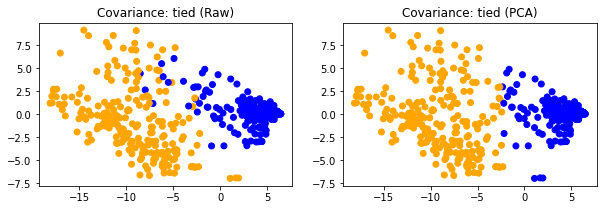

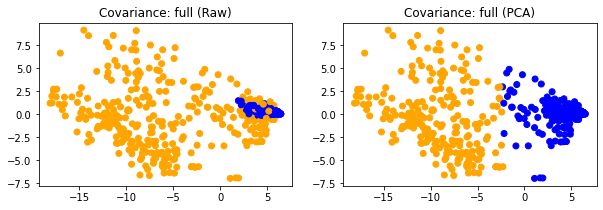

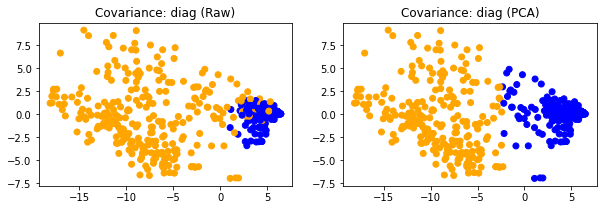

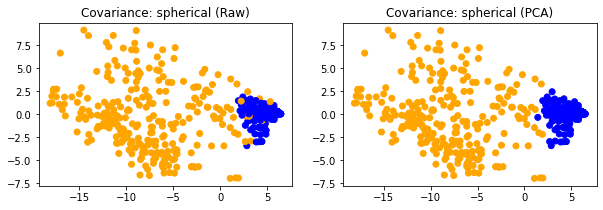

In [44]:
rawX = df.iloc[:, :9]           # Raw data columns
pcaX = df.iloc[:, 9:-1]         # PCA data columns

covTypes = ['tied', 'full', 'diag', 'spherical']        # Different covariance types
# 'full' (each component has its own general covariance matrix),
# 'tied' (all components share the same general covariance matrix),
# 'diag' (each component has its own diagonal covariance matrix),
# 'spherical' (each component has its own single variance).

for cov in covTypes:
    gmmRaw = mixture.GaussianMixture(n_components=2, covariance_type=cov).fit(rawX)
    labelRaw = gmmRaw.predict(rawX)     # Prediction for Raw data
    gmmPCA = mixture.GaussianMixture(n_components=2, covariance_type=cov).fit(pcaX)
    labelPCA = gmmPCA.predict(pcaX)     # Prediction for PCA data

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    colors = {0: 'blue', 1: 'orange'}
    ax1.scatter(df['X'], df['Y'], c=[colors[i] for i in labelRaw])
    ax1.set_title('Covariance: '+cov+' (Raw)')
    ax2.scatter(df['X'], df['Y'], c=[colors[i] for i in labelPCA])
    ax2.set_title('Covariance: '+cov+' (PCA)')
    print(cov, 'pca matches:', sum(data['class']==labelPCA))
    print(cov, 'raw matches:', sum(data['class']==labelRaw))

# Covariance Type 'spherical' best! Save into df as 'gmmRaw' and 'gmmPCA' columns
df['gmmRaw'] = labelRaw
df['gmmPCA'] = labelPCA

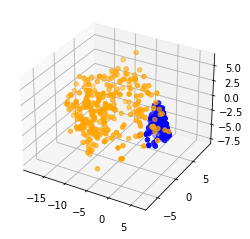

In [45]:
# 3D GMM - Raw data
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(df['gmmRaw']==1)]['X'],df[(df['gmmRaw']==1)]['Y'],df[(df['gmmRaw']==1)]['Z'], color='orange')
ax.scatter3D(data[(df['gmmRaw']==0)]['X'],df[(df['gmmRaw']==0)]['Y'],df[(df['gmmRaw']==0)]['Z'], color='blue')

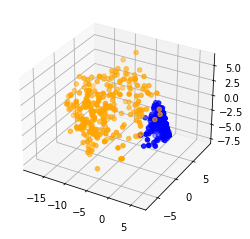

In [46]:
# 3D GMM - PCA data
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(data[(df['gmmPCA']==1)]['X'],df[(df['gmmPCA']==1)]['Y'],df[(df['gmmPCA']==1)]['Z'], color='orange')
ax.scatter3D(data[(df['gmmPCA']==0)]['X'],df[(df['gmmPCA']==0)]['Y'],df[(df['gmmPCA']==0)]['Z'], color='blue')

In [47]:
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,X,Y,Z,K-Means Raw,K-Means PCA,gmmRaw,gmmPCA
0,5,1,1,1,2,1,3,1,1,4.437523,0.140152,1.739688,0,0,0,0
1,5,4,4,5,7,10,3,2,1,-4.842940,-4.875919,-0.861617,1,1,1,1
2,3,1,1,1,2,2,3,1,1,4.594002,-0.603916,-0.027812,0,0,0,0
3,6,8,8,1,3,4,3,7,1,-5.145849,3.458943,2.032486,1,1,1,1
4,4,1,1,3,2,1,3,1,1,4.072230,-0.037962,-0.055371,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,4.928586,-0.445218,0.130176,0,0,0,0
695,2,1,1,1,2,1,1,1,1,5.916401,0.197057,-0.606264,0,0,0,0
696,5,10,10,3,7,3,8,10,2,-10.319805,7.208938,-0.794679,1,1,1,1
697,4,8,6,4,3,4,10,6,1,-6.449759,2.488778,-1.817876,1,1,1,1


# Model Accuracy

<b>K-Means Model Accuracy</b>

In [48]:
print('2D all data K means accuracy:',sum(data['class']==IID_Rnk.T[0])) #2D k means
print('3D all data K means accuracy:',sum(data['class']==IIID_Rnk.T[0]),'     (same as 2D all just different plotting)') 
#3D k means (THE SAME AS 2D JUST DIFFERENT IN PLOTTING)
print('2D 2 principal components k means accuracy:',sum(data['class']==IID_PCA_Rnk.T[0]))#k means on 2D PCA data
print('3D 3 principal components k means accuracy:',sum(data['class']==IIID_PCA_Rnk.T[0]))#k means on 3D PCA dat

2D all data K means accuracy: 669
3D all data K means accuracy: 669      (same as 2D all just different plotting)
2D 2 principal components k means accuracy: 669
3D 3 principal components k means accuracy: 669


It's important to note that the 3-dimensional and 2-dimensional K-means differ only in the plotting. Both use 9 columns and rely on PCA ONLY for plotting so we expect their results to be the same and they are. The only result that might differ is the K-means ran on the PCA data, in this case using only the first 2 and 3 principal components. We can see that we did not have a  different results when running K-means on the 2-dimensional and 3-dimensional PCA data when compared to K-means ran on all the data excluding the PCA columns. 

                  K-Means Raw


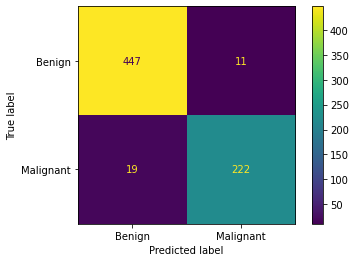

In [49]:
y_true = data['class']
y_pred = df['K-Means Raw']
np.array(confusion_matrix(y_true, y_pred).ravel()).reshape(2,2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),display_labels=['Benign','Malignant'])
disp.plot() 
print('\033[1m' + '                  K-Means Raw')

In [50]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
TR = (tp+tn)/(tn+fn+tp+fp)
print("True Total Rate: ",TR)

True Malignant Rate:  0.921161825726141
True Benign Rate:  0.9759825327510917
True Total Rate:  0.9570815450643777


Overall, K-Means model seems to be about 95.7% accurate. It seems to be more accurate when it comes to predicting benign than malignant tumors. This could be atributed to the way that the benign tumor datapoints have a much denser and closer cluster than the malignant tumor datapoints, most likely due to the nature of malignant tumors (not having consistent characteristics). Additionally, our data had more benign tumors which may have also affected prediction capability.

                  K-Means PCA


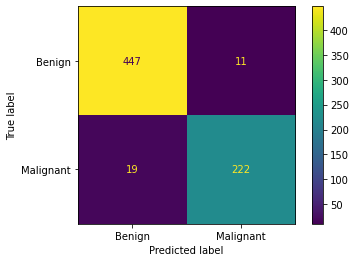

In [51]:
y_true = data['class']
y_pred = df['K-Means PCA']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),display_labels=['Benign','Malignant'])
disp.plot() 
print('\033[1m' + '                  K-Means PCA')

In [52]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
TR = (tp+tn)/(tn+fn+tp+fp)
print("True Total Rate: ",TR)

True Malignant Rate:  0.921161825726141
True Benign Rate:  0.9759825327510917
True Total Rate:  0.9570815450643777


<b>GMM Model Accuracy</b>

In [54]:
# Model Accuracy for GMM
print('GMM (Raw) Accuracy:', sum(data['class']==df['gmmRaw']))
print('GMM (PCA) Accuracy:', sum(data['class']==df['gmmPCA']))

GMM (Raw) Accuracy: 657
GMM (PCA) Accuracy: 671


            GMM Raw - Confusion Matrix


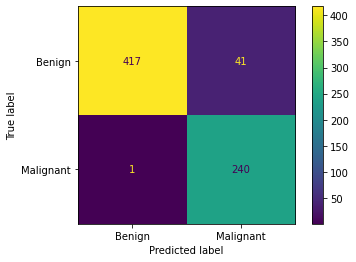

In [61]:
# Gaussian Mixture Models - Raw
y_true = data['class']
yRaw = df['gmmRaw']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, yRaw),display_labels=['Benign','Malignant'])
disp.plot() 

tn, fp, fn, tp = confusion_matrix(y_true, yRaw).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
TR = (tp+tn)/(tn+fn+tp+fp)
print('\033[1m' + '            GMM Raw - Confusion Matrix')

In [56]:
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
print("True Total Rate: ",TR)

True Malignant Rate:  0.995850622406639
True Benign Rate:  0.9104803493449781
True Total Rate:  0.9399141630901288


            GMM PCA - Confusion Matrix


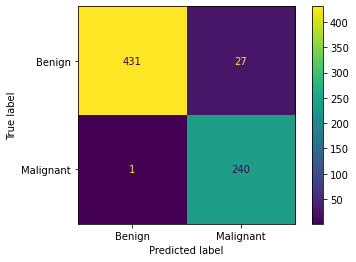

In [62]:
# Gaussian Mixture Models - PCA
y_true = data['class']
yPCA = df['gmmPCA']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, yPCA),display_labels=['Benign','Malignant'])
disp.plot() 

tn, fp, fn, tp = confusion_matrix(y_true, yPCA).ravel()
TPR = tp/(tp + fn)
TNR = tn/(tn + fp)
TR = (tp+tn)/(tn+fn+tp+fp)
print('\033[1m' + '            GMM PCA - Confusion Matrix')

In [63]:
print("True Malignant Rate: ",TPR)
print("True Benign Rate: ", TNR)
print("True Total Rate: ",TR)

True Malignant Rate:  0.995850622406639
True Benign Rate:  0.9410480349344978
True Total Rate:  0.9599427753934192


With GMM, we can see that the model did better when working with PCA data although not by much. Additionally, GMM is much better at predicting malignant tumors than K-means but slightly worse at prediciting benign. This could be due to the nature of our data: GMM tends to be better for elongated data where as K-means prefers hard boundaries and rounder clusters which the benign cluster showed but the malignant cluster did not.

# Predicted VS Actual Cluster Assignment Plots

Final comparison of plots created from the methods used to cluster versus the actual cluster assignments

Run the next line for interactable plots 

In [ ]:
%matplotlib qt

Now we can compare cluster assignments to the actual assignments taken from the class column in the data dataframe:

In [121]:
df['Actual Assignemnts'] = data['class']
df.iloc[0:30,:]

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,X,Y,Z,K-Means Raw,K-Means PCA,gmmRaw,gmmPCA,Actual Assignemnts
0,5,1,1,1,2,1,3,1,1,4.437523,0.140152,1.739688,0,0,0,0,0
1,5,4,4,5,7,10,3,2,1,-4.842940,-4.875919,-0.861617,1,1,1,1,0
2,3,1,1,1,2,2,3,1,1,4.594002,-0.603916,-0.027812,0,0,0,0,0
3,6,8,8,1,3,4,3,7,1,-5.145849,3.458943,2.032486,1,1,1,1,0
4,4,1,1,3,2,1,3,1,1,4.072230,-0.037962,-0.055371,0,0,0,0,0
5,8,10,10,8,7,10,9,7,1,-15.048932,-0.494624,-0.608806,1,1,1,1,1
6,1,1,1,1,2,10,3,1,1,1.672482,-6.933980,-2.222819,0,0,1,1,0
7,2,1,2,1,2,1,3,1,1,4.939692,0.392510,-0.749314,0,0,0,0,0
8,2,1,1,1,2,1,1,1,5,5.422234,0.850633,-0.770715,0,0,0,0,0
9,4,2,1,1,2,1,2,1,1,4.623556,0.385364,1.012204,0,0,0,0,0


As expected, they are the same for the most part with a couple errors made here and there.

Text(0.5, 0.92, 'GMM PCA Cluster Assignments')

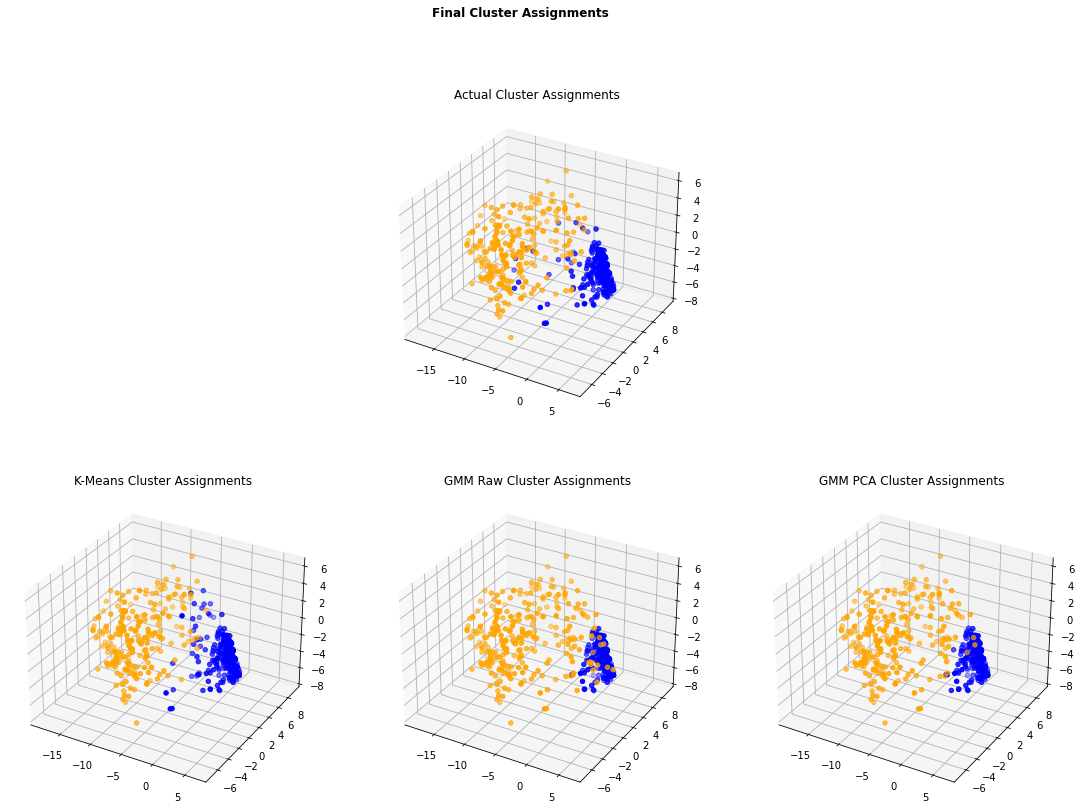

In [116]:
fig = plt.figure(figsize=(19,13))  
ax1 = fig.add_subplot(232, projection='3d')
ax2 = fig.add_subplot(234, projection='3d')
ax3 = fig.add_subplot(235, projection='3d')
ax4 = fig.add_subplot(236, projection='3d')

ax1.scatter3D(data[(data['class']==1)]['X'],data[(data['class']==1)]['Y'],data[(data['class']==1)]['Z'], color='orange')
ax1.scatter3D(data[(data['class']==0)]['X'],data[(data['class']==0)]['Y'],data[(data['class']==0)]['Z'], color='blue')
fig.suptitle('Final Cluster Assignments', fontweight ="bold")
ax1.set_title('Actual Cluster Assignments')


ax2.scatter3D(data[(df['K-Means Raw']==1)]['X'],df[(df['K-Means Raw']==1)]['Y'],
             df[(df['K-Means Raw']==1)]['Z'], color='orange')
ax2.scatter3D(data[(df['K-Means Raw']==0)]['X'],df[(df['K-Means Raw']==0)]['Y'],
             df[(df['K-Means Raw']==0)]['Z'], color='blue')
ax2.set_title('K-Means Cluster Assignments')

ax3.scatter3D(data[(df['gmmRaw']==1)]['X'],df[(df['gmmRaw']==1)]['Y'],
             df[(df['gmmRaw']==1)]['Z'], color='orange')
ax3.scatter3D(data[(df['gmmRaw']==0)]['X'],df[(df['gmmRaw']==0)]['Y'],
             df[(df['gmmRaw']==0)]['Z'], color='blue')
ax3.set_title('GMM Raw Cluster Assignments')

ax4.scatter3D(data[(df['gmmPCA']==1)]['X'],df[(df['gmmPCA']==1)]['Y'],
             df[(df['gmmPCA']==1)]['Z'], color='orange')
ax4.scatter3D(data[(df['gmmPCA']==0)]['X'],df[(df['gmmPCA']==0)]['Y'],
             df[(df['gmmPCA']==0)]['Z'], color='blue')
ax4.set_title('GMM PCA Cluster Assignments')

Our K-means model using PCA and the raw data had an equal accuracy of 95.7% and the exact same results with 92.1% accuracy for predicting malignant tumors and 97.6% for predicting benign.
GMM using spherical covariance and run on raw data had an overall accuracy of 93.9% with 99.6% accuracy for predicting malignant tumors and 91.0% for predicting benign.
GMM using spherical covariance and run on PCA data (top 3 principal components) had an overall accuracy of 95.9% with 99.6% accuracy for predicting malignant tumors and 94.1% for predicting benign.